# Financial analysis of OZON 

Before analyzing OZON, we need to prepare the data. First, let's import the necessary libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gspread
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
%matplotlib inline


Next, connect to Google Sheets using the GSpread library and extract OZON’s data.

In [2]:
# Connect to Google Sheets using service account credentials 
gc = gspread.service_account(filename=r'C:\Users\first-scarab (key).json')

# Access OZON financial datasets 
ozon_financial_statements = gc.open('OZON - отчетность')
ozon_operating_results = gc.open('OZON - показатели деятельности')
ozon_financial_ratios = gc.open('OZON - финансовые коэффициенты')

# Assign specific worksheets to variables 
balanceq_sheet = ozon_financial_statements.get_worksheet(1) # Balance Sheet
plq_sheet = ozon_financial_statements.get_worksheet(3)      # Profit & Loss  
cfq_sheet = ozon_financial_statements.get_worksheet(5)      # Cash Flow 
orq_sheet = ozon_operating_results.get_worksheet(1)         # Operating Results 
fr_sheet = ozon_financial_ratios.get_worksheet(1)           # Financial Ratios 

# Convert sheets to Pandas DataFRames
ozon_blq = pd.DataFrame(balanceq_sheet.get('B3:ZZ45'))
ozon_plq = pd.DataFrame(plq_sheet.get('B3:ZZ26'))
ozon_cfq = pd.DataFrame(cfq_sheet.get('B3:ZZ53'))
market_place = pd.DataFrame(orq_sheet.get('B3:ZZ6'))
metrics = pd.DataFrame(orq_sheet.get('B11:ZZ16'))
revenue_structure = pd.DataFrame(orq_sheet.get('B21:ZZ29'))
cost_structure = pd.DataFrame(orq_sheet.get('B35:ZZ42'))
ozon_fr = pd.DataFrame(fr_sheet.get('B3:ZZ42'))

# Display settings
pd.set_option('display.precision', 2)

After that, we need to clean it: 

- remove all missing values 

- fill empty spaces 

- ensure uniform formatting 

- standardize date displays

- scale numerical values for compactness


In [3]:
ozon_blq.dropna(inplace=True) # Remove missing values
ozon_blq.reset_index(drop=True, inplace=True) # Reset index to remove gaps
ozon_blq.iloc[1:, 1:] = ozon_blq.iloc[1:, 1:].apply(pd.to_numeric) # Convert string values to numeric
ozon_blq.iloc[1:, 1:] = ozon_blq.iloc[1:, 1:] / 1000000 # Scale values to billions (divide by 1M)
ozon_blq.iloc[0, 1:] = pd.to_datetime(ozon_blq.iloc[0, 1:], format='%d.%m.%Y').dt.strftime('%d-%m-%Y') # Convert date format to DD-MM-YYYY


ozon_plq.dropna(inplace=True)
ozon_plq.reset_index(drop=True, inplace=True)
ozon_plq.iloc[1:, 1:] = ozon_plq.iloc[1:, 1:].apply(pd.to_numeric)
ozon_plq.iloc[1:, 1:] = ozon_plq.iloc[1:, 1:] / 1000000 
ozon_plq.iloc[0, 1:] = ozon_plq.iloc[0, 1:].str.slice_replace(1, 5, 'q') # Format dates as quarters
ozon_plq.iloc[0, 1:] = ozon_plq.iloc[0, 1:].str.slice_replace(-2)


ozon_cfq.dropna(inplace=True)
ozon_cfq.reset_index(drop=True, inplace=True)
ozon_cfq.iloc[1:, 1:] = ozon_cfq.iloc[1:, 1:].apply(pd.to_numeric)
ozon_cfq.iloc[1:, 1:] = ozon_cfq.iloc[1:, 1:] / 1000000
ozon_cfq.iloc[0, 3:] = ozon_cfq.iloc[0, 3:].str.slice_replace(1, 5, 'q')
ozon_cfq.iloc[0, 3:] = ozon_cfq.iloc[0, 3:].str.slice_replace(-2)
ozon_cfq.iloc[0, 1:3] = ozon_cfq.iloc[0, 1:3].str.slice_replace(1, 6, 'm')
ozon_cfq.iloc[0, 1:3] = ozon_cfq.iloc[0, 1:3].str.slice_replace(-2)


market_place.iloc[1:, 0] = market_place.iloc[1:, 0].map(str) + ', ' + market_place.iloc[1:, 1].map(str) # Join two text columns into one
market_place.drop(columns=1, inplace=True)
market_place.iloc[0, 0] = 'Metric'
market_place.columns = range(market_place.shape[1])
market_place.iloc[1:, 2:] = market_place.iloc[1:, 2:].apply(pd.to_numeric)
market_place.iloc[0, 2:] = market_place.iloc[0, 2:].str.slice_replace(1, 5, 'q')
market_place.iloc[0, 2:] = market_place.iloc[0, 2:].str.slice_replace(-2)
market_place.fillna(0, inplace=True) # Fill NA values with zeros


metrics.iloc[1:, 0] = metrics.iloc[1:, 0].map(str) + ', ' + metrics.iloc[1:, 1].map(str)
metrics.drop(metrics.columns[1:5], inplace=True, axis=1)
metrics.columns = range(metrics.shape[1])
metrics.ffill(inplace=True, axis=1) # Forward fill NA values
metrics.iloc[1:, 1:] = metrics.iloc[1:, 1:].replace(r'^\s*$', np.nan, regex=True)
metrics.bfill(inplace=True, axis=1) # Backward fill remaining NA values
metrics.iloc[1:, 1:] = metrics.iloc[1:, 1:].apply(pd.to_numeric)
metrics.iloc[0, 1:] = metrics.iloc[0, 1:].str.slice_replace(1, 5, 'q')
metrics.iloc[0, 1:] = metrics.iloc[0, 1:].str.slice_replace(-2)


revenue_structure.iloc[1:, 0] = revenue_structure.iloc[1:, 0].map(str) + ', ' + revenue_structure.iloc[1:, 1].map(str)
revenue_structure.drop(revenue_structure.columns[1:4], axis=1, inplace=True)
revenue_structure.columns = range(revenue_structure.shape[1])
revenue_structure.fillna(0, inplace=True)
revenue_structure.iloc[0, 1:] = revenue_structure.iloc[0, 1:].str.slice_replace(1, 5, 'q')                                                      
revenue_structure.iloc[0, 1:] = revenue_structure.iloc[0, 1:].str.slice_replace(-2)                                                     
revenue_structure.iloc[1:, 1:] = revenue_structure.iloc[1:, 1:].apply(pd.to_numeric)
revenue_structure.iloc[1:, 1:] = revenue_structure.iloc[1:, 1:] / 1000000

 
cost_structure.iloc[1:, 0] = cost_structure.iloc[1:, 0].map(str) + ', ' + cost_structure.iloc[1:, 1].map(str)
cost_structure.drop(cost_structure.columns[1:4], axis=1, inplace=True)
cost_structure.columns = range(cost_structure.shape[1])
cost_structure.iloc[0, 1:] = cost_structure.iloc[0, 1:].str.slice_replace(1, 5, 'q')
cost_structure.iloc[0, 1:] = cost_structure.iloc[0, 1:].str.slice_replace(-2)
cost_structure.iloc[1:, 1:] = cost_structure.iloc[1:, 1:].apply(pd.to_numeric)*-1 # Convert costs to positive values
cost_structure.iloc[1:, 1:] = cost_structure.iloc[1:, 1:] / 1000000
                                                  

ozon_fr.iloc[0, 1:] = pd.to_datetime(ozon_fr.iloc[0, 1:], format='%d.%m.%Y').dt.strftime('%d-%m-%Y')
ozon_fr.iloc[1:, 1:] = ozon_fr.iloc[1:, 1:].apply(pd.to_numeric)

Now, let’s start visualizing the data. First, we’ll plot GMV (Gross Merchandise Value) to assess the overall sales performance.

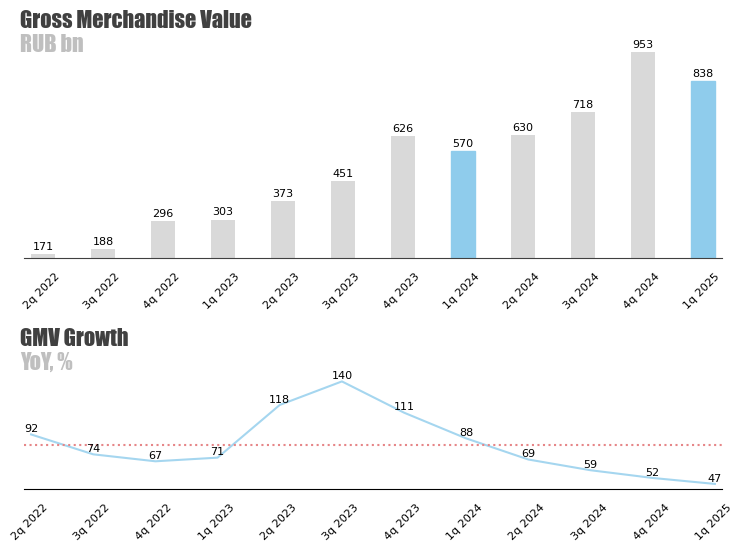

In [4]:
# Basic settings for visualizations
colors = ['#AFD5C1', '#E68688', '#F1D078', '#8FCCEC', '#EEAF9D', '#C4B2D6', '#A0A0A0']
font = {'fontname': 'Impact'}
f_colors = ['#404040', '#BFBFBF', '#D9D9D9']


# Control the number of quarters analyzed in each graph
quarters_analysed = 12
dates_q = ozon_plq.iloc[0, -quarters_analysed:]  # Format dates as quarterly periods (e.g., 4Q 2024)
dates_n = ozon_blq.iloc[0, -quarters_analysed:]  # Format dates as numeric values (e.g., 31-12-2024)


# Create a bar chart of Gross Merchandise Value (GMV) with a growth line plot below
GMV_figure, (gmv, gmvp) = plt.subplots(2, 1, figsize=(9, 6), height_ratios=(1.5, 1))
bars = gmv.bar(dates_q, market_place.iloc[1, -quarters_analysed:], color=f_colors[2], width=0.4)
for i in [-1, -5]:                    # Highlight the last quarter and its year-ago equivalent by changing their colors
    bars[i].set_color(colors[3])
gmv.set_ylim(market_place.iloc[1, -quarters_analysed:].min() * 0.9, market_place.iloc[1, -quarters_analysed:].max() * 1.1)
plt.subplots_adjust(hspace=0.4)
gmv.xaxis.set_tick_params(rotation=45, labelsize=8) # Rotate x-axis ticks and adjust label size
gmv.yaxis.set_visible(False) 
gmv.margins(x=0.01)
gmv.xaxis.set_ticks_position('none')   # Remove all axis ticks
for key, spine in gmv.spines.items():  # Remove three spines (keeping only the bottom spine) for cleaner visualization
    if key != 'bottom':
        spine.set_visible(False)
gmv.spines['bottom'].set_color(f_colors[0])
for i in range(len(dates_q)):
    gmv.text(dates_q.iloc[i],  market_place.iloc[1, -quarters_analysed + i] + market_place.iloc[1, -quarters_analysed:].max() * 0.02, str(round(market_place.iloc[1, -quarters_analysed + i])),
             ha='center', fontsize=8)
GMV_figure.text(0.12, 0.88, 'Gross Merchandise Value', fontsize=16, color=f_colors[0], **font)
GMV_figure.text(0.12, 0.84, 'RUB bn', fontsize=16, color=f_colors[1], **font)
gmvp.plot(dates_q, market_place.iloc[3, -quarters_analysed:], color=colors[3], alpha=0.8)
gmvp.xaxis.set_tick_params(rotation=45, labelsize=8)
for key, spine in gmvp.spines.items():
    if key != 'bottom':
        spine.set_visible(False)
gmvp.xaxis.set_ticks_position('none')
gmvp.margins(x=0.01)
gmvp.yaxis.set_visible(False)
gmvp.set_ylim(market_place.iloc[3, -quarters_analysed:].min() * 0.9, market_place.iloc[3, -quarters_analysed:].max() * 1.3)
for i in range(len(dates_q)):
    gmvp.text(dates_q.iloc[i], market_place.iloc[3, -quarters_analysed + i] + market_place.iloc[3, -quarters_analysed:].max() * 0.02,
              str(round(market_place.iloc[3, -quarters_analysed + i])), ha='center', fontsize=8)
GMV_figure.text(0.12, 0.35, 'GMV Growth', fontsize=16, color=f_colors[0], **font)
GMV_figure.text(0.12, 0.31, 'YoY, %', fontsize=16, color=f_colors[1], **font)
gmvp.axhline(y=market_place.iloc[3, -quarters_analysed:].mean(), color=colors[1], linestyle="dotted") # Add a horizontal line at the mean value
plt.show()

In Q1 2025, GMV grew by 46.9% year over year, increasing from RUB 570 billion to RUB 838 billion, which is objectively a strong result. However, the GMV growth rate continued to slow, hitting a historic low of 47% and falling below the historic average (red line). To understand the reasons behind this, we need to examine the order volume and client base.

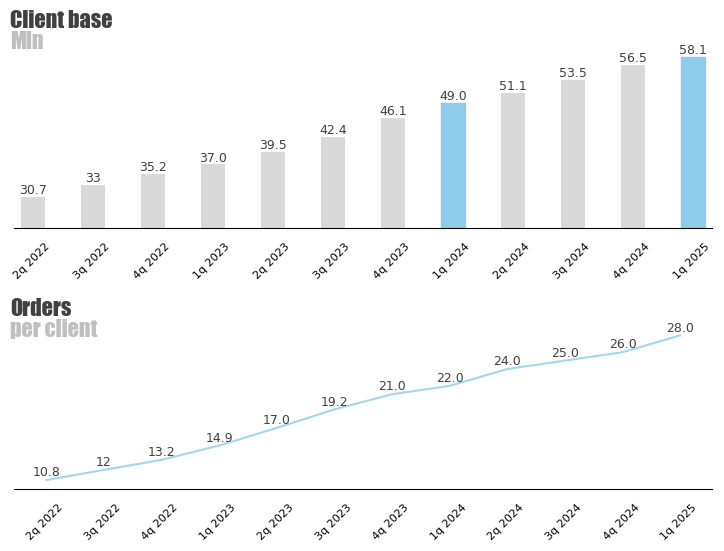

In [6]:
# Create a client base graph
Metrics_figure, (cbv, avo) = plt.subplots(2, 1, figsize=(9, 6))
mbars = cbv.bar(dates_q, metrics.iloc[2, -quarters_analysed:], color=f_colors[2], width=0.4)
for i in [-1,-5]:
    mbars[i].set_color(colors[3])
cbv.xaxis.set_tick_params(rotation=45, labelsize=8)
cbv.set_ylim(metrics.iloc[2, -quarters_analysed:].min() * 0.8, metrics.iloc[2, -quarters_analysed:].max() * 1.1)
cbv.yaxis.set_visible(False)
for key, spine in cbv.spines.items():
    if key != 'bottom':
        spine.set_visible(False)
cbv.margins(x=0.01)
cbv.xaxis.set_ticks_position('none')
for i in range(len(dates_q)):
    cbv.text(dates_q.iloc[i], metrics.iloc[2, -quarters_analysed + i] + metrics.iloc[2, -quarters_analysed:].max() * 0.013,
             str(round(metrics.iloc[2, -quarters_analysed + i], 1)), ha='center', fontsize=9, color=f_colors[0])
cbv.margins(x=0.01)
Metrics_figure.text(0.12, 0.88, 'Client base', fontsize=16, color=f_colors[0], **font)
Metrics_figure.text(0.12, 0.845, 'Mln', fontsize=16, color=f_colors[1], **font)
avo.plot(dates_q, metrics.iloc[4, -quarters_analysed:], color=colors[3], alpha=0.8)
avo.xaxis.set_tick_params(rotation=45, labelsize=8)
avo.yaxis.set_visible(False)
avo.xaxis.set_ticks_position('none')
for key, spine in avo.spines.items():
    if key != 'bottom':
        spine.set_visible(False)
Metrics_figure.text(0.12, 0.40, 'Orders', fontsize=16, color=f_colors[0], **font)
Metrics_figure.text(0.12, 0.365, 'per client', fontsize=16, color=f_colors[1], **font)
avo.set_ylim(metrics.iloc[4, -quarters_analysed:].min() * 0.9, metrics.iloc[4, -quarters_analysed:].max() * 1.2)
for i in range(len(dates_q)):
    avo.text(dates_q.iloc[i], metrics.iloc[4, -quarters_analysed + i] + metrics.iloc[4, -quarters_analysed:].max() * 0.02, str(round(metrics.iloc[4, -quarters_analysed + i], 1)),
             ha='center', fontsize=9, color=f_colors[0])
plt.subplots_adjust(hspace=0.3)
plt.show()


In the last quarter, OZON added 1.6 million new clients, reaching a total of 58.1 million people. On average, over the last 12 quarters, OZON has been gaining around 2.6 million new clients per quarter, which is significantly higher than the latest result. The reason for the slowdown lies in the scale of the organization. As it gradually approaches critical mass, attracting new customers becomes increasingly difficult, and the impact of adding 2 million more people diminishes as the client base reaches new highs. However, there is still some room for improvement. The workforce in Russia comprises 74 million people, and retirees amount to approximately 23 million; hence, the potential for quantifiable growth persists.

The same can be said about the average number of orders per client. In Q1 2025, it increased to 28 orders, from 22 orders a year earlier. For comparison, Amazon's average number of orders per client is 71; so, OZON can atleast double in this regard. Businesses like OZON Fresh (its food retail branch) and other FMCG segments will help the company achieve higher order frequency. 

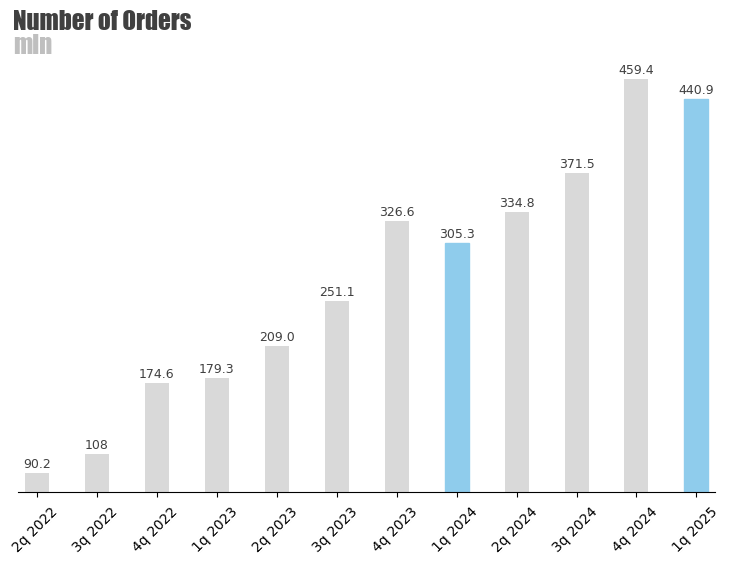

In [8]:
# Create an order volume graph
Orders_figure, onv = plt.subplots(figsize=(9, 6))
bars = onv.bar(dates_q, metrics.iloc[1, -quarters_analysed:], width=0.4, color=f_colors[2])
for i in [-1,-5]:
    bars[i].set_color(colors[3]) 
onv.xaxis.set_tick_params(rotation=45, labelsize=10)
onv.yaxis.set_visible(False)  
for key, spine in onv.spines.items():
    if key != 'bottom':
        spine.set_visible(False)
onv.margins(x=0.01)
onv.set_ylim(metrics.iloc[1, -quarters_analysed:].min() * 0.8, metrics.iloc[1, -quarters_analysed:].max() * 1.1)
for i in range(len(dates_q)):
    onv.text(dates_q.iloc[i], metrics.iloc[1, -quarters_analysed + i] + metrics.iloc[1, -quarters_analysed:].max() * 0.01, 
             str(round(metrics.iloc[1, -quarters_analysed + i], 1)), ha='center', fontsize=9, color=f_colors[0])
Orders_figure.text(0.12, 0.88, 'Number of Orders', fontsize=18, color=f_colors[0], **font)
Orders_figure.text(0.12, 0.84, 'mln', fontsize=18, color=f_colors[1], **font)
plt.show()


Driven by higher purchase frequency and a growing customer base, the total number of orders rose by 44.4% YoY, to 440.9 million, and is strongly expected to continue in this direction. 

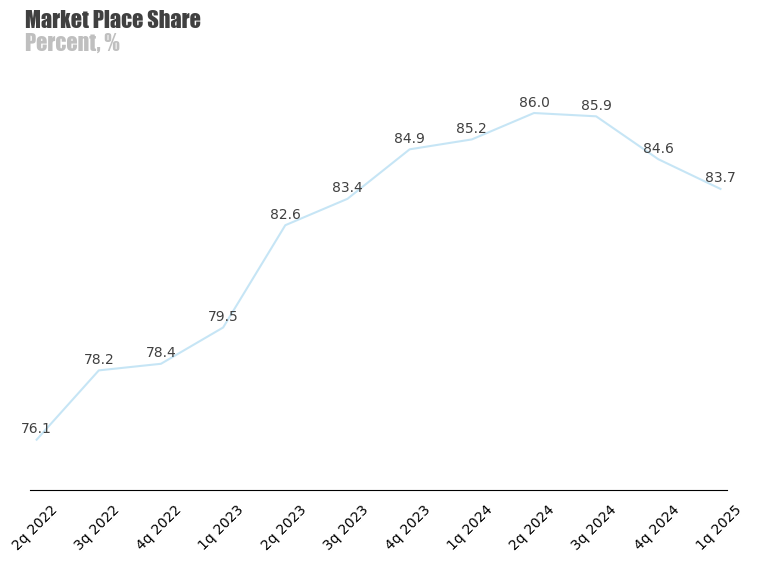

In [9]:
# Create a market place share graph
Market_share_figure, msv = plt.subplots(figsize=(9, 6))
msv.plot(dates_q, market_place.iloc[2, -quarters_analysed:], color=colors[3], alpha=0.5)
msv.xaxis.set_tick_params(rotation=45, labelsize=10)
msv.yaxis.set_visible(False)
for key, spine in msv.spines.items():
    if key != 'bottom':
        spine.set_visible(False)
msv.xaxis.set_ticks_position('none')
for i in range(len(dates_q)):
    msv.text(dates_q.iloc[i], market_place.iloc[2, -quarters_analysed + i] + 0.2, 
             str(round(market_place.iloc[2, -quarters_analysed + i], 1)), fontsize=10, color=f_colors[0], ha='center')
msv.set_ylim(market_place.iloc[2, -quarters_analysed:].min() * 0.98, market_place.iloc[2, -quarters_analysed:].max() * 1.03)
msv.margins(x=0.01)
Market_share_figure.text(0.12, 0.88, 'Market Place Share', fontsize=16, color=f_colors[0], **font)
Market_share_figure.text(0.12, 0.842, 'Percent, %', fontsize=16, color=f_colors[1], **font)
plt.show()

The share of OZON's marketplace (third-party sales) in GMV has declined over the last two quarters but has consistently remained around 84%. In theory, this should be positive because selling own products is more profitable than earning commissions on third-party sales. However, in practice, it might not mean much. The company has a history of selling products at near-zero margins to attract new customers, so the increase in first-party sales may have little to no impact on overall profitability.

 

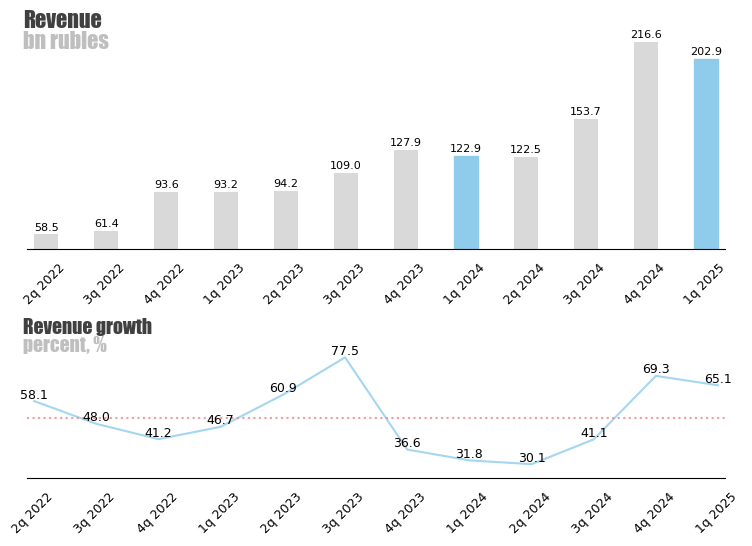

In [10]:
# Create a revenue graph
Revenue_figure, (rvv,rvg) = plt.subplots(2,1, figsize=(9, 6), height_ratios=(1.5, 1))
bars = rvv.bar(dates_q, ozon_plq.iloc[1, -quarters_analysed:], width=0.4, color=f_colors[2])
for i in [-1, -5]:
    bars[i].set_color(colors[3])
rvv.xaxis.set_tick_params(rotation=45, labelsize=9)
rvv.xaxis.set_ticks_position('none')
rvv.set_ylim(ozon_plq.iloc[1, -quarters_analysed:].min() * 0.8, ozon_plq.iloc[1, -quarters_analysed:].max() * 1.1)
Revenue_figure.text(0.12, 0.86, 'Revenue', fontsize=16, color=f_colors[0], **font)
Revenue_figure.text(0.12, 0.825, 'bn rubles', fontsize=16, color=f_colors[1], **font)
rvv.margins(x=0.01)
for i in range(len(dates_q)):
    rvv.text(dates_q.iloc[i], ozon_plq.iloc[1, -quarters_analysed + i] + ozon_plq.iloc[1, -quarters_analysed:].max() * 0.015,
             str(round(ozon_plq.iloc[1, -quarters_analysed + i], 1)), ha='center', fontsize=8)
rvv.yaxis.set_visible(False)
for key, spine in rvv.spines.items():
    if key != 'bottom':
        spine.set_visible(False)
plt.subplots_adjust(hspace=0.38)
revenue_growth = round(ozon_plq.iloc[1, -quarters_analysed - 4:].pct_change(periods=4).dropna() * 100, 1)
rvg.plot(dates_q, revenue_growth, color=colors[3], alpha=0.8)
rvg.xaxis.set_tick_params(rotation=45, labelsize=9)
rvg.xaxis.set_ticks_position('none')
rvg.set_ylim(revenue_growth.min() * 0.8, revenue_growth.max() * 1.2)
Revenue_figure.text(0.12, 0.35, 'Revenue growth', fontsize=14, color=f_colors[0], **font)
Revenue_figure.text(0.12, 0.32, 'percent, %', fontsize=14, color=f_colors[1], **font)
rvg.margins(x=0.01)
for i in range(len(dates_q)):
    rvg.text(dates_q.iloc[i], revenue_growth.iloc[i] + revenue_growth.max() * 0.015, 
             str(revenue_growth.iloc[i]), ha='center', fontsize=9)
rvg.yaxis.set_visible(False)
for key, spine in rvg.spines.items():
    if key != 'bottom':
        spine.set_visible(False)
rvg.axhline(y=revenue_growth.mean(), color=colors[1], alpha=0.8, linestyle='dotted')
plt.show()

Revenue dynamics are much stronger than GMV’s. It grew by 65.1% year over year, reaching RUB 202.9 billion, and its growth rate remains above the historic average (red line).

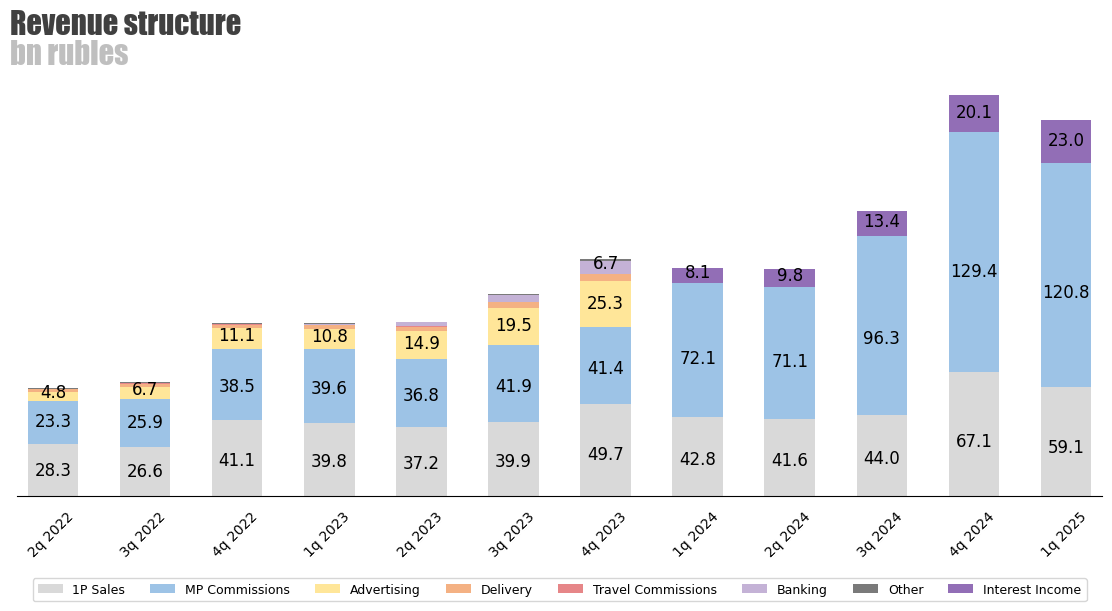

In [11]:
# Create a revenue structure graph
labels = ['1P Sales', 'MP Commissions', 'Advertising', 'Delivery', 'Travel Commissions', 'Banking', 'Other', 'Interest Income']
ozon_colors = ['#D9D9D9', '#9DC3E6', '#FFE699', '#F4B183', '#E68688','#C4B2D6', '#7A7A7A', "#926EB6"]

Revenue_str_figure, rsv = plt.subplots(figsize=(14, 6))
for i in range(len(revenue_structure.iloc[1:, -quarters_analysed:])):
    rsv.bar(dates_q, revenue_structure.iloc[1 + i, -quarters_analysed:], color=ozon_colors[i],
            bottom=revenue_structure.iloc[1:i + 1, -quarters_analysed:].sum(), label=labels[i], width=0.55) 
rsv.xaxis.set_tick_params(rotation=45, labelsize=10)
rsv.margins(x=0.01)
rsv.xaxis.set_ticks_position('none')
rsv.set_ylim(0, revenue_structure.iloc[1:, -quarters_analysed:].sum().max() * 1.15)
rsv.legend(loc='lower center', bbox_to_anchor=(0.5, -0.24), ncol=8, fontsize=9)
rsv.yaxis.set_visible(False)
for key, spine in rsv.spines.items():
    if key != 'bottom':
        spine.set_visible(False)
Revenue_str_figure.text(0.12, 0.88, 'Revenue structure', fontsize=22, **font, color=f_colors[0])
Revenue_str_figure.text(0.12, 0.83, 'bn rubles', fontsize=22, **font, color=f_colors[1])
for i in range(revenue_structure.iloc[1:, -quarters_analysed:].shape[0]):
    for j in range(revenue_structure.iloc[1:, -quarters_analysed:].shape[1]):
        if revenue_structure.iloc[1 + i, -quarters_analysed+j] > 4:
            rsv.text(dates_q.iloc[j], revenue_structure.iloc[1:2 + i, -quarters_analysed + j].sum() - revenue_structure.iloc[1 + i, -quarters_analysed + j] * 0.6, 
                     str(round(revenue_structure.iloc[1 + i, -quarters_analysed + j], 1)), ha='center', fontsize=12)
plt.show()


The main contributor is still marketplace commissions (since 2023, these also include ads, delivery, travel, and other revenue). They rose by 67.6% year over year, reaching RUB 120.8 billion. First-party sales rank second at RUB 59.1 billion, up 38.1% year over year. Interest income (formerly banking) grew 2.9-fold to RUB 23 billion and continues to show strong momentum.

<function matplotlib.pyplot.show(close=None, block=None)>

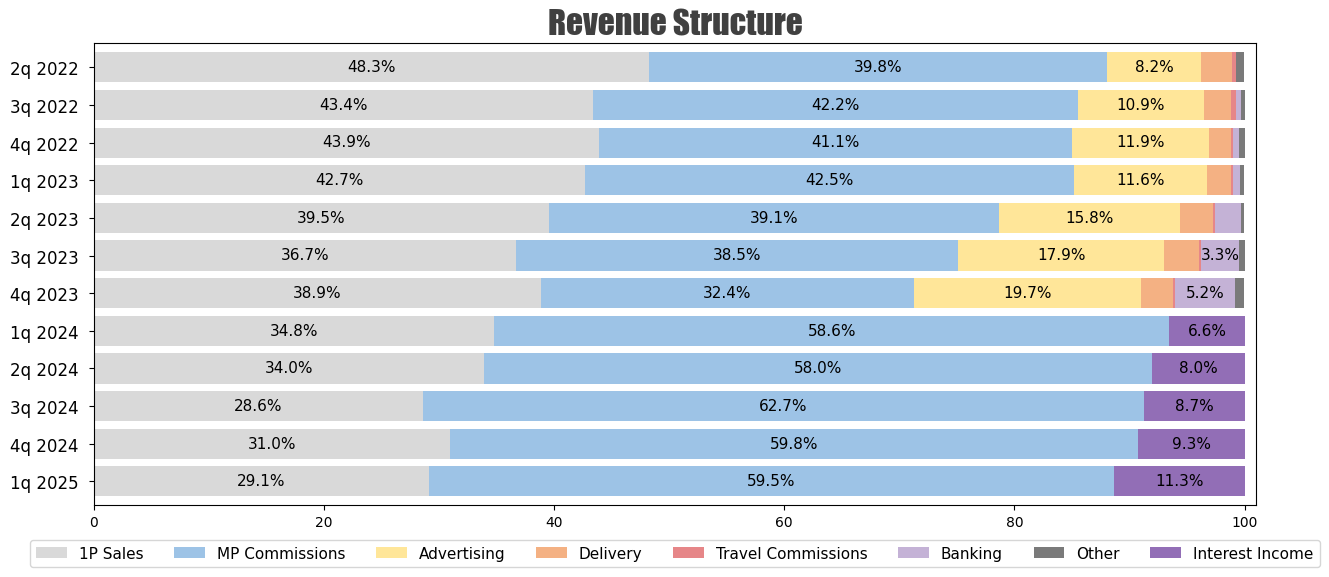

In [12]:
# Create a revenue pct graph
revenue_pct = round((revenue_structure.iloc[1:, -quarters_analysed:] / revenue_structure.iloc[1:, -quarters_analysed:].sum() * 100).astype(float), 2)
dates_line = pd.Series(range(quarters_analysed))

revenue_pct_figure, pcf = plt.subplots(figsize=(15, 6))
for i in range(len(revenue_pct)):
    pcf.barh(dates_line, width=revenue_pct.iloc[i], color=ozon_colors[i], label=labels[i], 
             left=revenue_pct.iloc[:i].sum())
for i in range(len(revenue_pct)):
    for j in range(revenue_pct.shape[1]):
        if revenue_pct.iloc[i, j] > 3:
            pcf.text(revenue_pct.iloc[:i + 1, j].sum() - revenue_pct.iloc[i, j] * 0.5, dates_line[j] + 0.1, 
                    str(round(revenue_pct.iloc[i, j], 1)) + '%', ha='center', fontsize=11)
pcf.set_title('Revenue Structure', fontsize=24, **font, color=f_colors[0])
pcf.invert_yaxis()
pcf.margins(x=0.01, y=0.02)
pcf.set_yticks(dates_line, dates_q, fontsize=12)
pcf.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=8, fontsize=11)
plt.show

This graph highlights the overall trend more effectively. Here, the increasing dominance of OZON's banking is more apparent. If it goes like this, in a few years OZON might start competing with the largest banks in Russia. Its client base is already larger than that of T-Bank (top 6 bank in Russia), which should be a concern for other bankers.

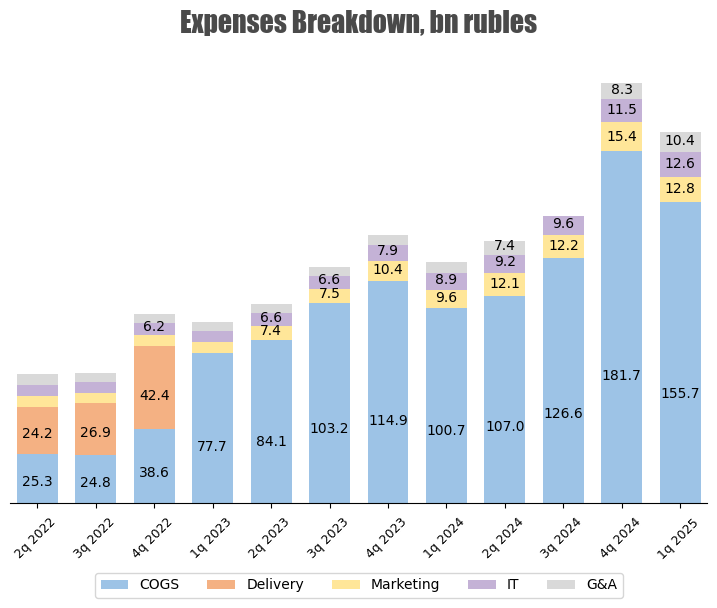

Total operating expenses RUB 191.6 bn
Pct change -53.8% YoY


In [14]:
# Create an expenses plot
ozon_colors_exp = ['#9DC3E6', '#F4B183', '#FFE699', '#C4B2D6', '#D9D9D9', '#E68688']
exp_str = -ozon_plq.iloc[6:11, -quarters_analysed:]
labels_exp=['COGS', 'Delivery', 'Marketing', 'IT', 'G&A']
width_r=0.35

Expenses_figure, expv = plt.subplots(figsize=(9, 6))
expv.set_title('Expenses Breakdown, bn rubles', fontsize=20, **font, color=f_colors[0], alpha=0.95)
for i in range(len(exp_str)):
    expv.bar(dates_q, exp_str.iloc[i, -quarters_analysed:], color=ozon_colors_exp[i],
             bottom=exp_str.iloc[:i, -quarters_analysed:].sum(), label=labels_exp[i], width=0.7)
expv.xaxis.set_tick_params(rotation=45, labelsize=9)
expv.margins(x=0.01)
expv.set_ylim(0, exp_str.iloc[:, -quarters_analysed:].sum().max() * 1.1)
expv.legend(loc='lower center', bbox_to_anchor=(0.5, -0.22), ncol=len(exp_str))
for i in range(exp_str.shape[0]):
    for j in range(exp_str.shape[1]):
        if exp_str.iloc[i, j] > 6:
            expv.text(dates_q.iloc[j], exp_str.iloc[:i, j].sum() + exp_str.iloc[i, j] * 0.35,
                      str(round(exp_str.iloc[i, -quarters_analysed + j], 1)), ha='center')
for key, spine in expv.spines.items():
    if key != 'bottom':
        spine.set_visible(False)
expv.yaxis.set_visible(False)
plt.show()
print(f"Total operating expenses RUB {round(-ozon_plq.iloc[6:11,-1].sum(), 1)} bn")
print(f"Pct change {round(-ozon_plq.iloc[6:11,-5:].sum().pct_change(4).dropna().item()*100, 1)}% YoY")


Total operating expenses amounted to RUB 191.6 billion, up 53.8% year over year. The main contributors are COGS and delivery (since Q4 2022, both have been reported together as COGS); they grew by 54.7% and now represent 81% of total expenses. The growth here is slightly slower compared to revenue, which has a positive impact on the operating margin.

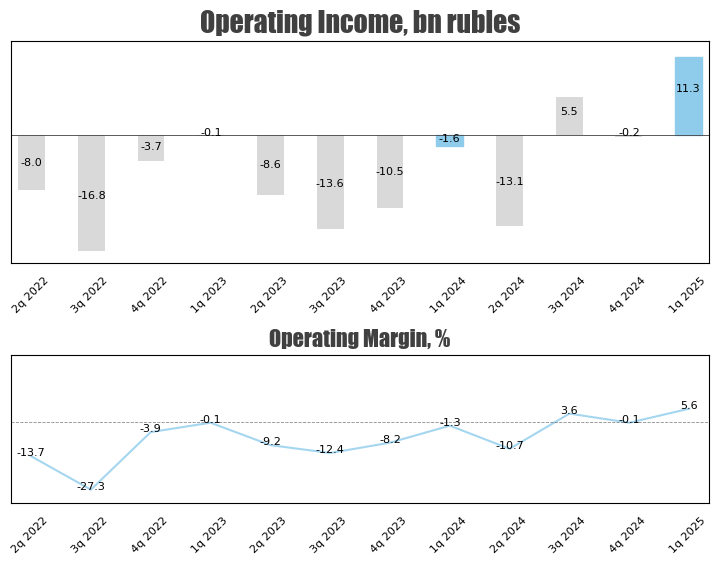

In [15]:
# Create an operating income graph
operating_maring = round((ozon_plq.iloc[11, -quarters_analysed:] / ozon_plq.iloc[1, -quarters_analysed:] * 100).astype(float), 1)

Oper_inc_figure, (opv, opm) = plt.subplots(2, 1, figsize=(9, 6), height_ratios=(1.5, 1))
bars = opv.bar(dates_q, ozon_plq.iloc[11, -quarters_analysed:], width=0.45, color=f_colors[2])
for i in [-1, -5]:
    bars[i].set_color(colors[3])
opv.xaxis.set_tick_params(rotation=45, labelsize=8)
opv.margins(x=0.01)
opv.set_ylim(ozon_plq.iloc[11, -quarters_analysed:].min() * 1.1, ozon_plq.iloc[11, -quarters_analysed:].max() * 1.2)
opv.axhline(y=0, color=f_colors[0], linewidth=0.6)
opv.yaxis.set_visible(False)
opv.xaxis.set_ticks_position('none')
opv.set_title('Operating Income, bn rubles', fontsize=20, **font, color=f_colors[0])
for i in range(len(ozon_plq.iloc[11, -quarters_analysed:])):
    opv.text(dates_q.iloc[i], ozon_plq.iloc[11, -quarters_analysed + i] * 0.55,
             str(round(ozon_plq.iloc[11, -quarters_analysed + i], 1)), fontsize=8, ha='center')
plt.subplots_adjust(hspace=0.5)
opm.plot(dates_q, operating_maring, color=colors[3], alpha=0.8)
opm.set_ylim(operating_maring.min() * 1.2, abs(operating_maring.min()))
opm.xaxis.set_tick_params(rotation=45, labelsize=8)
opm.axhline(y=0, color=f_colors[0], alpha=0.6, linewidth=0.6, ls='--')
opm.set_title('Operating Margin, %', color=f_colors[0], **font, fontsize=16)
opm.xaxis.set_ticks_position('none')
opm.yaxis.set_visible(False)
for i in range(len(dates_q)):
    opm.text(dates_q.iloc[i], operating_maring.iloc[i] + operating_maring.max() * 0.02, 
             str(round(operating_maring.iloc[i], 1)), ha='center', fontsize=8)
opm.margins(x=0.03)
plt.show()

Indeed, in Q1 2025, OZON’s operating margin grew to 5.6%, resulting in an operating profit of RUB 11.3 billion. This is a strong result compared to previous quarters. However, there remains ample room for growth. For example, Amazon’s operating margin exceeds 10%. Additionally, I believe the banking business has the potential to increase this figure further, though for now, these are just my speculations.

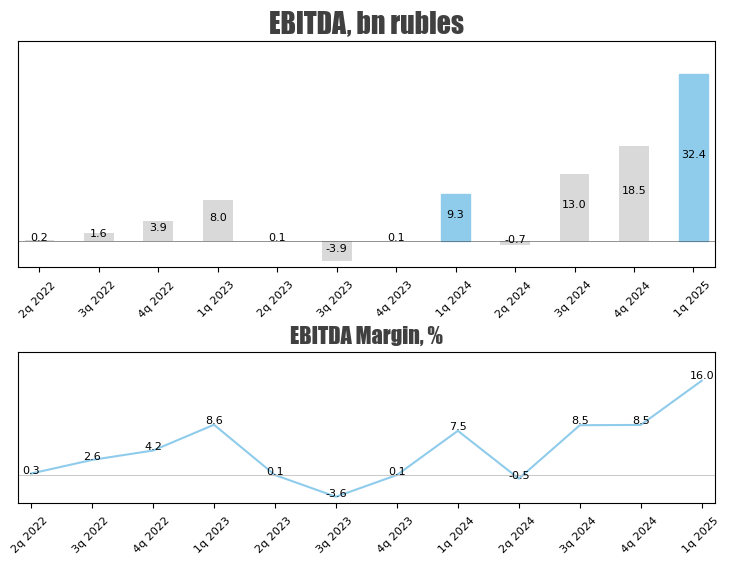

In [16]:
# Create an EBITDA graph
EBITDA_margin = round((ozon_plq.iloc[-1, -quarters_analysed:] / ozon_plq.iloc[1, -quarters_analysed:] * 100).astype(float), 2)

EBITDA_figure, (ebv, ebm) = plt.subplots(2, 1, figsize=(9,6), height_ratios=(1.5, 1))
bars = ebv.bar(dates_q, ozon_plq.iloc[-1, -quarters_analysed:], width=0.5, color=f_colors[2])
for i in [-1, -5]:
    bars[i].set_color(colors[3])
ebv.margins(x=0.01)
ebv.xaxis.set_tick_params(rotation=45, labelsize=8)
ebv.yaxis.set_visible(False)
ebv.axhline(y=0, color=f_colors[0], linewidth=0.4)
ebv.set_title('EBITDA, bn rubles', fontsize=20, color=f_colors[0], **font)
ebv.set_ylim(ozon_plq.iloc[-1, -quarters_analysed:].min() * 1.3, ozon_plq.iloc[-1, -quarters_analysed:].max() * 1.2)
for i in range(len(dates_q)):
    ebv.text(dates_q.iloc[i], ozon_plq.iloc[-1, -quarters_analysed + i] * 0.5, str(round(ozon_plq.iloc[-1, -quarters_analysed + i], 1)),
             ha='center', fontsize=8)
plt.subplots_adjust(hspace=0.45)
ebm.set_title('EBITDA Margin, %', fontsize=16, color=f_colors[0], **font)
ebm.plot(dates_q, EBITDA_margin, color=colors[3])
ebm.yaxis.set_visible(False)
ebm.xaxis.set_tick_params(rotation=45, labelsize=8)
ebm.margins(x=0.02)
ebm.set_ylim(EBITDA_margin.min() * 1.3, EBITDA_margin.max() * 1.3)
ebm.axhline(y=0, color=f_colors[1], linewidth=0.6)
for i in range(len(dates_q)):
    ebm.text(dates_q.iloc[i], EBITDA_margin.iloc[i] + EBITDA_margin.iloc[i].max() * 0.02, str(round(EBITDA_margin.iloc[i], 1)), 
             ha='center', fontsize=8)
plt.show()

The EBITDA situation looks even better. In the last quarter, it reached a record high of 16%, amounting to RUB 32.4 billion. Positive news for investors concerned about potential insolvency.



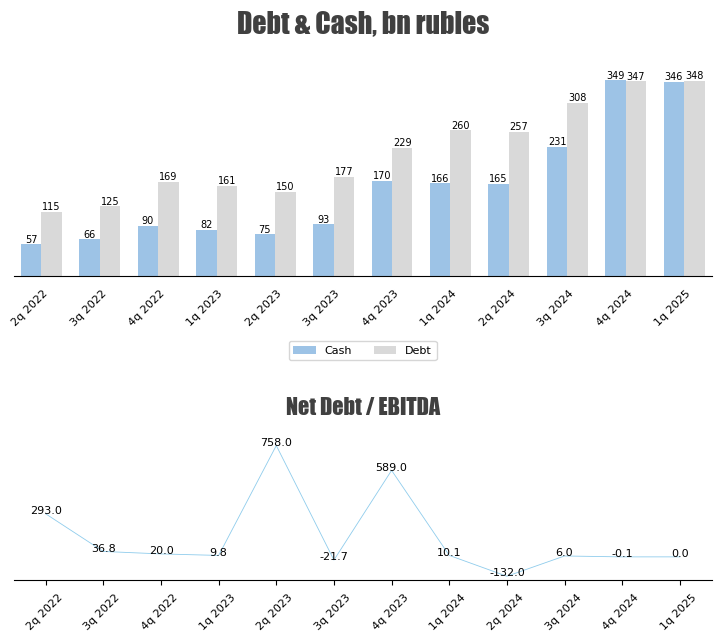

In [14]:
# Create a debt graph 
debt_cash = ozon_fr.iloc[[7,13], -quarters_analysed:] /1000000
width_debt = 0.35
labels_debt = ['Cash', 'Debt']

net_debt = round(((ozon_fr.iloc[13, -quarters_analysed:] / 1000000 - ozon_fr.iloc[7, -quarters_analysed:] / 1000000)).astype(float), 1).reset_index(drop=True)
EBITDA = round((ozon_plq.iloc[-1, -quarters_analysed:]).astype(float), 1).reset_index(drop=True)
Net_Debt_Ebitda = round(net_debt / EBITDA, 1) 

Debt_figure, (frd, fre) = plt.subplots(2, 1, figsize=(9, 7), height_ratios=(1.5, 1))
for i in range(debt_cash.shape[0]):
    frd.bar(dates_line + width_debt * i, debt_cash.iloc[i, :], width=width_debt, color=ozon_colors[1-i],
            label=labels_debt[i]) 
frd.xaxis.set_ticks(dates_line, dates_q, fontsize=8)  
frd.xaxis.set_tick_params(rotation=45, labelsize=8)
frd.set_title('Debt & Cash, bn rubles', fontsize=20, **font, color=f_colors[0])
frd.margins(x=0.01)
frd.set_ylim(0, debt_cash.max().max() * 1.2)
frd.legend(loc='lower center', bbox_to_anchor=(0.5, -0.38), ncol=len(labels_debt), fontsize=8)
frd.yaxis.set_visible(False)
for key, spine in frd.spines.items():
    if key != 'bottom': 
        spine.set_visible(False)
frd.xaxis.set_ticks_position('none')
for i in range(debt_cash.shape[0]):
    for j in range(debt_cash.shape[1]):
        frd.text(dates_line.iloc[j] + width_debt * i, debt_cash.iloc[i, j]+ debt_cash.max().max() * 0.01, str(round(debt_cash.iloc[i, j])),
                 ha='center', fontsize=7)
plt.subplots_adjust(hspace=0.75)
fre.set_title('Net Debt / EBITDA', fontsize=16, **font, color=f_colors[0])
fre.yaxis.set_visible(False)
for key, spine in fre.spines.items():
    if key !='bottom':
        spine.set_visible(False)
fre.xaxis.set_tick_params(rotation=45, labelsize=8)
fre.plot(dates_q, Net_Debt_Ebitda, color=colors[3], linewidth=0.6)
fre.set_ylim(Net_Debt_Ebitda.min() * 1.2, Net_Debt_Ebitda.max() * 1.2)
for i in range(len(Net_Debt_Ebitda)):
    fre.text(dates_q.iloc[i], Net_Debt_Ebitda.iloc[i], str(round(Net_Debt_Ebitda.iloc[i], 1)),
             ha='center', fontsize=8)
plt.show()

On top of that, the amounts of debt and cash have remained roughly stable over the last two quarters, at around RUB 350 billion. As a result, net debt is currently close to zero, and the net debt-to-EBITDA ratio reflects this. This should further reassure investors.

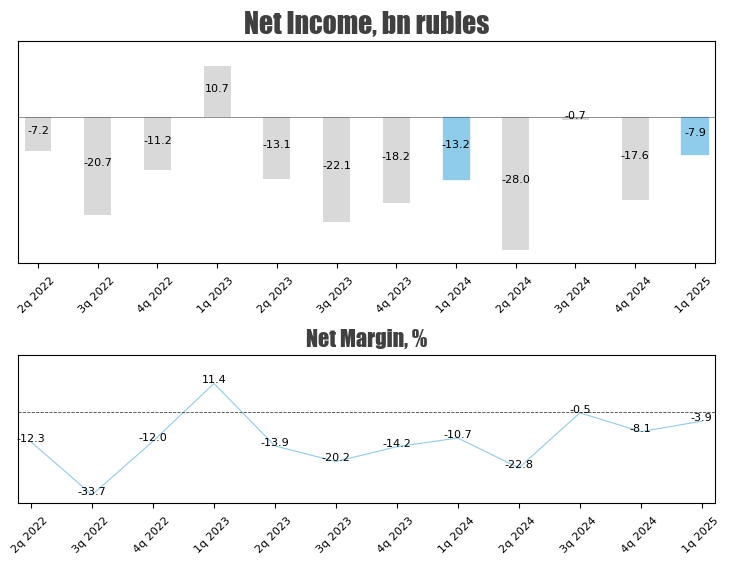

In [17]:
# Create a profit graph
net_margin = round((ozon_plq.iloc[19, -quarters_analysed:] / ozon_plq.iloc[1, -quarters_analysed:] * 100).astype(float), 2)

Profits_figure, (pfv, pfm) = plt.subplots(2,1, figsize=(9, 6), height_ratios=(1.5, 1))
bars = pfv.bar(dates_q, ozon_plq.iloc[19, -quarters_analysed:], width=0.45, color=f_colors[2])
for i in [-1, -5]:
    bars[i].set_color(colors[3])
pfv.xaxis.set_tick_params(rotation=45, labelsize=8)
pfv.set_title('Net Income, bn rubles', fontsize=20, **font, color=f_colors[0])
pfv.axhline(y=0, linewidth=0.4, color=f_colors[0])
pfv.margins(x=0.01)
pfv.set_ylim(ozon_plq.iloc[19, -quarters_analysed:].min() * 1.1, ozon_plq.iloc[19, -quarters_analysed:].max() * 1.5)
pfv.yaxis.set_visible(False)
for i in range(len(ozon_plq.iloc[19, -quarters_analysed:])):
    pfv.text(dates_q.iloc[i], ozon_plq.iloc[19, -quarters_analysed + i] * 0.5, 
             str(round(ozon_plq.iloc[19, -quarters_analysed + i], 1)), ha='center', fontsize=8)
plt.subplots_adjust(hspace=0.5)
pfm.plot(dates_q, net_margin, color=colors[3], linewidth=0.8)
pfm.set_title('Net Margin, %', fontsize=16, **font, color=f_colors[0])
pfm.yaxis.set_visible(False)
pfm.xaxis.set_tick_params(rotation=45, labelsize=8)
pfm.margins(x=0.02)
pfm.set_ylim(net_margin.min() * 1.1, net_margin.max() * 2)
pfm.axhline(y=0, color=f_colors[0], linewidth=0.6, ls='--')
for i in range(len(net_margin)):
    pfm.text(dates_q.iloc[i], net_margin.iloc[i] + net_margin.max() * 0.01, 
             str(round(net_margin.iloc[i], 1)), ha='center', fontsize=8)
plt.show()


Net income, however, remained negative. In Q1 2025, the loss amounted to RUB 7.9 billion, compared to RUB 13.2 billion a year earlier. The main culprit is interest expenses, which remain high as the Central Bank continues to keep the key rate at 20%. Although amortization offsets losses, it is not reflected in the P&L. The good news is that the Central Bank is highly likely to lower the key rate in the near future, so we can expect improvement on this front in the second half of 2025.

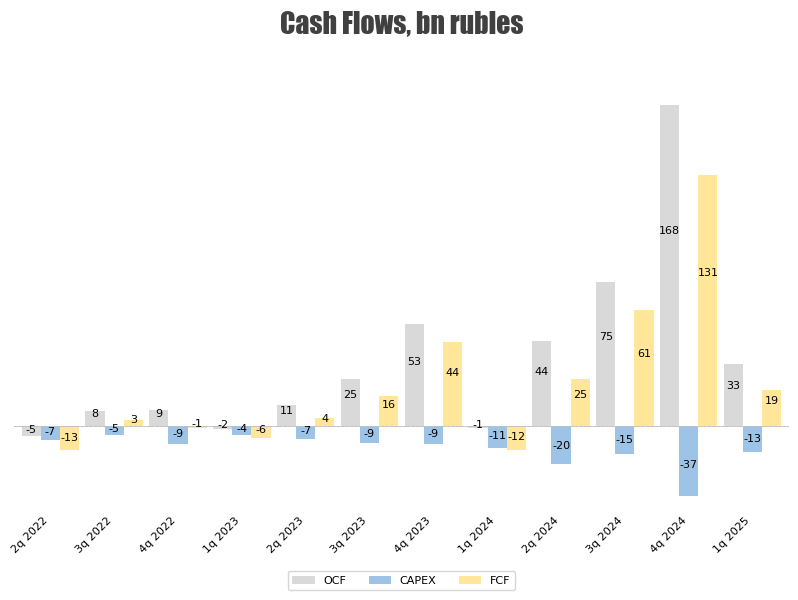

In [18]:
# Create a cashflow graph
cf_labels = ['OCF', 'CAPEX', 'FCF']
cash_flows = pd.DataFrame([ozon_cfq.iloc[20, -quarters_analysed:], ozon_cfq.iloc[42, -quarters_analysed:], (ozon_cfq.iloc[20, -quarters_analysed:] + ozon_cfq.iloc[42, -quarters_analysed:])], index=cf_labels)
cf_colors = ['#8FCCEC', '#D9D9D9','#F1D078']
cf_width = 0.3

CF_figure, cfv = plt.subplots(figsize=(10, 6))
for i in range(cash_flows.shape[0]):
    cfv.bar(dates_line + cf_width * i, cash_flows.iloc[i, :], color=ozon_colors[i], width=cf_width, label=cf_labels[i])
for i in range(cash_flows.shape[0]):
    for j in range(cash_flows.shape[1]):
        cfv.text(dates_line.iloc[j] + cf_width * i, cash_flows.iloc[i, j] * 0.6, str(round(cash_flows.iloc[i, j])),
                 ha='center', fontsize=8)
cfv.set_title('Cash Flows, bn rubles', fontsize=20, **font, color=f_colors[0])
cfv.xaxis.set_ticks(dates_line, dates_q, fontsize=8)
cfv.xaxis.set_tick_params(rotation=45, labelsize=8)
cfv.margins(x=0.01)
cfv.yaxis.set_visible(False)
for key, spine in cfv.spines.items():
    spine.set_visible(False)
cfv.xaxis.set_ticks_position('none')
cfv.axhline(y=0, color=f_colors[1], linewidth=0.6, ls='--')
cfv.set_ylim(cash_flows.min().min() * 1.1, cash_flows.max().max() * 1.2)
cfv.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(cf_labels), fontsize=8)
cfv.axhline(y=0, color=f_colors[1], alpha=0.8, linewidth=0.6)
plt.show()



Additionally, it is worth mentioning that as the company slows its expansion, its CAPEX is also beginning to decline, at least as a percentage of revenue. Looking ahead, once the high-interest debt is repaid, this could further contribute to overall profitability.

# Predictions

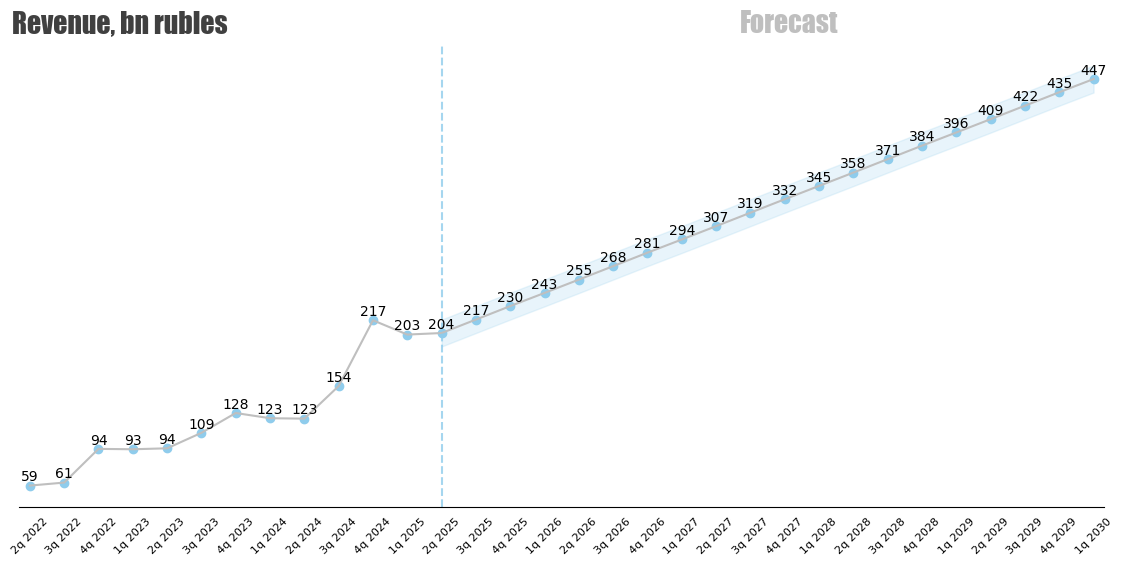

In [19]:
# Forecast revenue using time series 
model = LinearRegression()
revenue = ozon_plq.iloc[1, -quarters_analysed:].reset_index(drop=True)
dates = pd.to_datetime(dates_n, format='%d-%m-%Y').reset_index(drop=True)
days_since_start = (dates - dates.min()).dt.days # Display dates as the number of days since the earliest day for preditions 
model.fit(days_since_start.values.reshape(-1, 1), revenue)

last_date = dates.max() + pd.DateOffset(years=5)
quarterly_dates = pd.Series(pd.date_range(start=dates.max() + pd.DateOffset(months=3), end=last_date, freq='Q'))
all_dates = pd.concat([dates, quarterly_dates], ignore_index=True)


all_days_since_start = (all_dates - dates.min()).dt.days  
x = all_days_since_start.iloc[-20:].values.reshape(-1, 1)
predictions = model.predict(x)
future_revenue = pd.concat([revenue, round(pd.Series(predictions), 3)], ignore_index=True)

all_dates_q = all_dates.dt.quarter.astype(str) +'q ' + all_dates.dt.year.astype(str)

deviations = model.predict(all_days_since_start.iloc[:-20].values.reshape(-1, 1))
mae = mean_absolute_error(revenue, pd.Series(deviations))


# Visualize predictions 
Pred_fig, prv = plt.subplots(figsize=(14, 6))
prv.scatter(all_dates_q, future_revenue , color=colors[3], label='Actual Sales')
prv.plot(all_dates_q, future_revenue, color=f_colors[1], label='Regression Line')
prv.fill_between(all_dates_q.iloc[-20:], pd.to_numeric(future_revenue.iloc[-20:]+mae), 
                 pd.to_numeric(future_revenue.iloc[-20:]-mae), alpha=0.2, color=colors[3])
prv.xaxis.set_tick_params(rotation=45, labelsize=8)
prv.margins(x=0.01)
prv.yaxis.set_visible(False)
for i in range(len(all_dates_q)):
    prv.text(all_dates_q.iloc[i], future_revenue.iloc[i] + future_revenue.max() * 0.01, str(round(future_revenue.iloc[i])), 
             ha='center')
for key, spine in prv.spines.items():
    if key !='bottom':
        spine.set_visible(False)
prv.xaxis.set_ticks_position('none')
prv.axvline(x=all_dates_q.iloc[-20], linestyle='--', color=colors[3], alpha=0.8)
Pred_fig.text(0.64, 0.9, 'Forecast', fontsize=20, **font, color=f_colors[1])
Pred_fig.text(0.12, 0.9, 'Revenue, bn rubles', fontsize=20, **font, color=f_colors[0])
plt.show()

Current revenue projections imply a 25% CAGR over the next five years. A moderate figure given historical performance. Let's forecast the stock's future value. 

In [ ]:
#Assumptions
tax_rate = np.linspace(14 / 100, 20 / 100, 20)      # Assume the tax rate will rise to 20%
wacc = 0.2
capex_coef = np.linspace(-8 / 100, -6 / 100, 20)    # Assume the CAPEX will decrease from 8% to %6 as a percentage of revenue
ebit_margin = np.linspace(5 / 100, 10 / 100, 20)    # Assume the EBIT margin will grow from 5% to 10%
NWC_coef = -0.01
terminal_growth = 0.05
da = np.linspace(-85 / 100, -100 / 100, 20)         # Assume the Amortization as % of CAPEX will grow from 85% to 100%

#Projections
projection = pd.DataFrame({'Dates':all_dates_q.iloc[-20:], 'Revenue':round(pd.to_numeric(future_revenue.iloc[-20:]), 2)})
projection['EBIT'] = round(projection['Revenue'] * ebit_margin, 2)
projection['CAPEX'] = round(projection['Revenue'] * capex_coef, 2)
projection['Amort'] = round(projection['CAPEX'] * da, 2)
projection['Tax'] = round(projection['EBIT'] * -tax_rate, 2)
projection['NWC'] = round(projection['Revenue'] * NWC_coef, 2)
projection['FCF'] = round(projection.iloc[:,2:].sum(axis=1), 2)
projection['WACC'] = round(1 / (1+wacc/4)**pd.Series(range(1, len(projection) + 1) , index=projection.index), 2)
projection['DFCF'] = round(projection['FCF'] * projection['WACC'], 2)
projection['EBITDA'] = round(projection['EBIT'] + projection['Amort'], 2)
projection.reset_index(inplace=True, drop=True)

final_fcf = projection['FCF'].iloc[-4:].sum()
terminal_value = (final_fcf * (1 + terminal_growth)) / (wacc - terminal_growth)
pv_terminal = terminal_value * projection['WACC'].iloc[-4:].mean()


enterprise_value = projection['DFCF'].sum() + pv_terminal 
net_debt = (ozon_fr.iloc[[7,8], -1].sum() - ozon_fr.iloc[13, -1]) / 1_000_000
equity_value = enterprise_value - net_debt

shares = ozon_fr.iloc[17, -1]
fair_price = equity_value * 1_000_000_000 / shares # Calculate a fair price per share


ebitda_multiple = 12 # Current multiple
fair_price_mul = ebitda_multiple * projection['EBITDA'].iloc[-4:].sum() * projection['WACC'].iloc[-4:].mean() * 1_000_000_000 / shares # Calculate a fair price per share using EBITDA multiple

current_price = ozon_fr.iloc[21, -1] # Current OZON's price

potential_table = pd.DataFrame({
    'Current price': current_price,
    'Method 1': round(fair_price), 
    'Method 2': round(fair_price_mul)},
    index=['Valuation']).T
potential_table['%'] = round((potential_table['Valuation'] - potential_table['Valuation'].iloc[0]) / potential_table['Valuation'].iloc[0] * 100)
potential_table

,Valuation,%
Current price,3929.5,0.0
Method 1,2326.0,-41.0
Method 2,6111.0,56.0


The DCF model suggests a fair price of RUB 2,326 per share (41% below the current price), whereas the multiple-based approach estimates RUB 6,111 (56% above the current price). The reason for this discrepancy lies in the WACC, which affects the two approaches differently. Compared to the DCF model, the multiple-based approach is more robust to changes in WACC and is therefore more stable.

Currently, Russia’s key rate is extremely high, around 20%, which leads to significant undervaluation of companies when using the DCF method. To illustrate this, I built a sensitivity table showing how the fair price varies depending on WACC assumptions. 

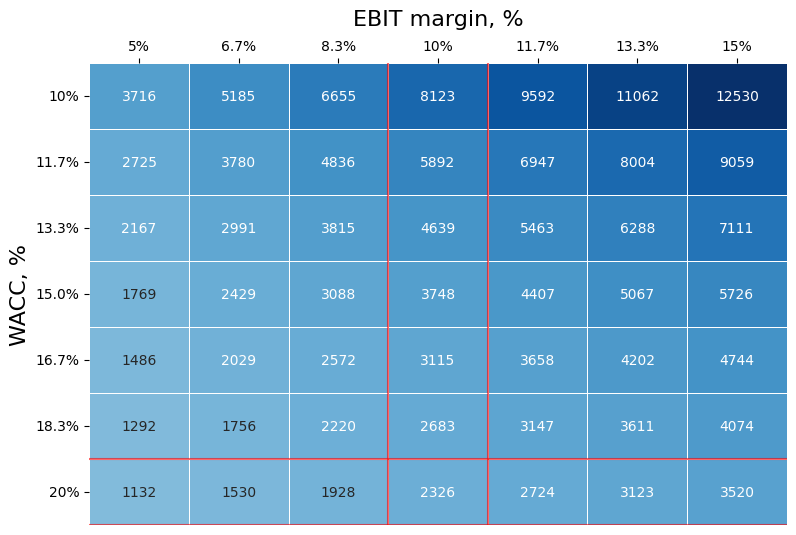

               Valuation     %
Current price     3929.5   0.0
Method 1          2326.0 -41.0
Method 2          6111.0  56.0

LTM EBITDA 2025/2030  RUB 63.3 / RUB 268.8 bn


In [22]:
# Create a sensitivy table 
WACC_range = [int(x * 100) if (x * 100).is_integer() else round(x * 100, 1)  for x in np.linspace(0.1, wacc, 7)]
EBIT_marg_ranges = np.linspace(0.05, 0.15, 7)
EBIT_margins = pd.DataFrame([np.linspace(0.05, b, 20) for b in EBIT_marg_ranges], index=EBIT_marg_ranges.round(3)).T.round(8)
EBIT_labels = [int(b * 100) if (b * 100) % 1 < 0.05 else round(b * 100, 1) for b in EBIT_marg_ranges]


sensitivity_WACC = pd.DataFrame(columns=[f"{e}%" for e in EBIT_labels], index=[f"{w}%" for w in WACC_range])
for i, w in enumerate(WACC_range): 
    for j , e in enumerate(EBIT_margins):
        EBIT = round(projection['Revenue'] * EBIT_margins[e], 2) 
        TAX = round(EBIT * -tax_rate, 2)
        FCF = EBIT + TAX + projection['CAPEX'] + projection['NWC'] + projection['Amort'] 
        WACC = round((1 / (1 + (w / 100) / 4)) ** pd.Series(range(1, len(projection) + 1), index=projection.index), 2) 
        DCF_sum = (FCF * WACC).sum() 
        Final_FCF = FCF.iloc[-4:].sum()
        TV = (Final_FCF * (1 + terminal_growth)) / (w / 100 - terminal_growth) 
        PV_TV = TV * WACC.iloc[-4:].mean()  
        fair_price_n = (PV_TV + DCF_sum - net_debt) * 1_000_000_000 / shares               
        sensitivity_WACC.iloc[i, j] = round((fair_price_n))
    

#Create a sensitivity map 
sens_values = sensitivity_WACC.values.astype(int)

Figure_sens_wacc, swf = plt.subplots(figsize=(9,6))
swf = sns.heatmap(sens_values, xticklabels=sensitivity_WACC.columns, yticklabels=sensitivity_WACC.index, 
                  center=fair_price, annot=True, fmt=".0f", cmap='Blues', 
                  linewidths=0.5, ax=swf, cbar=False)
swf.tick_params(axis='x', which='both', top=True, labeltop=True, labelbottom=False)
swf.xaxis.set_ticks_position('top')
swf.yaxis.set_tick_params(rotation=0)
swf.xaxis.set_label_position('top')  # Move the label to the top
swf.set_xlabel('EBIT margin, %', fontsize=16, labelpad=10)  
swf.set_ylabel('WACC, %', fontsize=16)
swf.axvline(3, color='red', alpha=0.6)
swf.axvline(4, color='red', alpha=0.6)
swf.axhline(6, color='red', alpha=0.6)
swf.axhline(7, color='red', alpha=0.6)
plt.show()
print(potential_table, end='\n\n')
print(f"LTM EBITDA 2025/2030  RUB {round(ozon_plq.iloc[-1, -4:].sum(), 1)} / RUB {round(projection['EBITDA'].iloc[-4:].sum(), 1)} bn")



As you can see, with the same forecasted EBITDA of RUB 268.6 billion and a 10% EBIT margin, the fair price changes significantly depending on the WACC. Historically, OZON's WACC has fluctuated between 13% and 15%; hence, a fair price range of RUB 3,750 to RUB 4,640 appears most reasonable.

Now, let’s build another sensitivity table, this time for the EBITDA multiple.

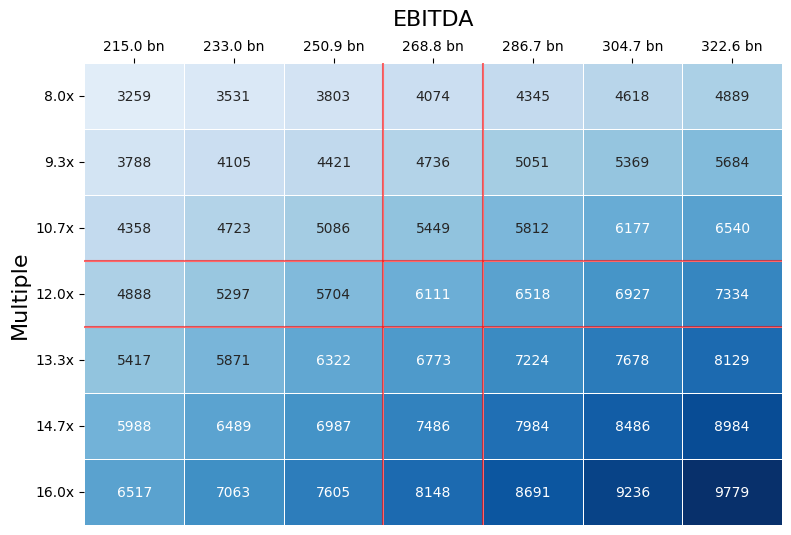

               Valuation     %
Current price     3929.5   0.0
Method 1          2326.0 -41.0
Method 2          6111.0  56.0

LTM EBITDA 2025/2030  RUB 63.3 / RUB 268.8 bn


In [23]:


# Sensitivity analysis 
EBITDA_multpl_range = np.linspace(8, 16, 7).round(1)
EBITDA_range = np.linspace(projection['EBITDA'].iloc[-4:].sum() * 0.8, projection['EBITDA'].iloc[-4:].sum()*1.2, 7).round(1)  
  
sensitivity_table = pd.DataFrame(columns=[f"{e} bn" for e in EBITDA_range], index=[f"{b}x" for b in EBITDA_multpl_range])
 
for  ebitda in EBITDA_range:
    sensitivity_table[f"{ebitda} bn"] = (ebitda * EBITDA_multpl_range* projection['WACC'].iloc[-4:].mean() * 1_000_000_000 / shares).round().astype(int)


# Create a Sensitivity heatmap
Sensitivity_figure, sng = plt.subplots(figsize=(9,6))
sng = sns.heatmap(sensitivity_table, center=fair_price_mul, annot=True, fmt=".0f", cmap='Blues', 
                  linewidths=0.5, ax=sng, cbar=False)  
sng.tick_params(axis='x', which='both', top=True, labeltop=True, labelbottom=False)
sng.xaxis.set_ticks_position('top')
sng.yaxis.set_tick_params(rotation=0)
sng.xaxis.set_label_position('top')  # Move the label to the top
sng.set_xlabel('EBITDA', fontsize=16, labelpad=10)  
sng.set_ylabel('Multiple', fontsize=16)
sng.axvline(3, color='red', alpha=0.6)
sng.axvline(4, color='red', alpha=0.6)
sng.axhline(3, color='red', alpha=0.6)
sng.axhline(4, color='red', alpha=0.6)
plt.show()
print(potential_table, end='\n\n')
print(f"LTM EBITDA 2025/2030  RUB {round(ozon_plq.iloc[-1, -4:].sum(), 1)} / RUB {round(projection['EBITDA'].iloc[-4:].sum(), 1)} bn")



Here, the evaluation seems more balanced, with no skewness toward the extremes. This forecast is based on the historic average EV/EBITDA of 12 and the assumption that LTM EBITDA will grow from RUB 63.3 billion in Q1 2025 to RUB 268.8 billion in Q1 2030. The expectations for EBITDA might seem overly optimistic, but in reality, OZON already earns more than RUB 30 billion in EBITDA per quarter; thus, the forecast implies slightly more than a doubling of EBITDA over the next five years. 

Personally, I prefer the multiple-based approach when evaluating fast-growing companies. DCF models tend to underestimate the potential of such companies due to the difficulty in making adequate long-term assumptions.


### Conclusions 

- OZON continues to expand its business and increase sales, but the growth rate is gradually slowing as the company approaches critical mass.

- EBITDA margin has improved significantly, reassuring investors about insolvency risks.

- Although net debt remains near zero, high interest rates continue to pressure profitability, keeping net income negative.

- DCF valuations appear extremely pessimistic due to the high key rate. Adjusting the approach using the historical WACC suggests a fair price range of RUB 3,750 to RUB 4,640.

- The multiple-based approach estimates a fair price of RUB 6,100. This method is preferable due to its resilience to changes in WACC and the company's specific characteristics.

Overall, OZON appears to be a medium-risk, high-reward investment. Its stock has three main growth drivers: a potential lowering of the key rate, continued improvements in profitability, and a shift in market sentiment regarding insolvency risks.

Risks: 

- OZON can revert to sacrificing its margins for the sake of faster growth, potentially leading to a negative reevaluation. 

- Solvency risks could arise if margins turn negative, though this is highly unlikely.